# Introduction

The purpose of this project is to determine which aircraft make and models are the most likely to suffer safety incidents in order to inform the purchasing decisions of aviation stakeholders. The project will make recommendations about which aircraft are likely to be unsafe, but will also make recommendations about which aircraft are the least likely to suffer a safety incident.

# Step 1: import packages and read the CSV into memory

First things first, let's set the stage for the analysis. We'll need to import all the packages we intend to use, and load our data into the memory of the notebook as a pandas dataframe. I've done all of this and also displayed a preview of the data in the cell below.

In [1]:
#import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#load csv as dataframe and display preview
df = pd.read_csv('data/Aviation_Data.csv', low_memory=False)
df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


# Step 2: remove as many uncessary columns as possible

Next, we need to narrow the scope of our analysis to only what is relevant to the core business question. I did extensive exploration of the data before making a decision about which variables are relevant to my analysis, so it's most efficient for me to just drop the columns I don't plan to use right off the bat.

In [2]:
#drop all of the columns I do not plan to use in my analysis
df=df.drop(axis=1, labels=
        ['Investigation.Type', 'Accident.Number', 'Location', 'Country', 'Latitude', 'Longitude', 'Airport.Code', 'Airport.Name', 'Aircraft.Category', 'Registration.Number', 'FAR.Description', 'Schedule', 'Purpose.of.flight', 'Air.carrier', 'Broad.phase.of.flight', 'Publication.Date', 'Report.Status']
       )

Now, let's get a general summary of the missing and duplicate values in the data.

In [3]:
#Display the total number of NaN entires in each column.
df.isna().sum()

Event.Id                   1459
Event.Date                 1459
Injury.Severity            2459
Aircraft.damage            4653
Make                       1522
Model                      1551
Amateur.Built              1561
Number.of.Engines          7543
Engine.Type                8536
Total.Fatal.Injuries      12860
Total.Serious.Injuries    13969
Total.Minor.Injuries      13392
Total.Uninjured            7371
Weather.Condition          5951
dtype: int64

In [4]:
### find total number of duplicate rows
df.duplicated().value_counts()

False    88846
True      1502
dtype: int64

# Step 3: Clean the data

## Dropping Duplicates
First, let's just remove all the duplicated records. This will be nice and easy!

In [5]:
#drop all duplicate rows and confirm there are no more duplicates
df = df.drop_duplicates()
df.duplicated().value_counts()

False    88846
dtype: int64

## Placeholders and Missing Values

### Event ID
Now, we need to remove or fill in the missing and placeholder values. I've determined that the best way to do this will be to just go column-by-column and decide on the best solution for each one individually. I'll start with the Event Id column because it is the first.

In [6]:
#Remove all NaNs from Event Id
df=df.dropna(subset=['Event.Id'])

### Injury Severity
Next, I will work with the injury severity column. The data in this column is extremely irregular and redundant with other columns in the dataframe, but I think a simple fatal or non-fatal distinction is useful to me, so I will simplify it to that.

In [7]:
#Show the irregular data contained in this column
df['Injury.Severity'].value_counts().head(20)

Non-Fatal      67336
Fatal(1)        6165
Fatal           5262
Fatal(2)        3705
Incident        2211
Fatal(3)        1146
Fatal(4)         808
Fatal(5)         235
Minor            217
Serious          173
Fatal(6)         161
Unavailable       96
Fatal(7)          56
Fatal(8)          51
Fatal(10)         32
Fatal(9)          18
Fatal(14)         11
Fatal(11)         10
Fatal(13)          9
Fatal(12)          8
Name: Injury.Severity, dtype: int64

In [8]:
#This cell standardizes the non-fatal values and drops unkowns/NaNs.
df['Injury.Severity'] = df['Injury.Severity'].replace(to_replace=['Incident', 'Minor', 'Serious'], value='Non-Fatal')
df = df.drop(df[df['Injury.Severity'] == 'Unavailable'].index)
df.dropna(axis=0, subset=['Injury.Severity'], inplace=True)
df['Injury.Severity'].value_counts().head(20)

Non-Fatal    69937
Fatal(1)      6165
Fatal         5262
Fatal(2)      3705
Fatal(3)      1146
Fatal(4)       808
Fatal(5)       235
Fatal(6)       161
Fatal(7)        56
Fatal(8)        51
Fatal(10)       32
Fatal(9)        18
Fatal(14)       11
Fatal(11)       10
Fatal(13)        9
Fatal(12)        8
Fatal(20)        5
Fatal(15)        5
Fatal(18)        5
Fatal(23)        4
Name: Injury.Severity, dtype: int64

In [9]:
#This cell standardizes the Fatal entries based on their length. Anything longer than 5 characters is just set to 'Fatal'.
df['Injury.Severity'] = df['Injury.Severity'].map(lambda x: 'Fatal' if x[:5]=='Fatal' else x)

In [10]:
#Display the cleaned column
df['Injury.Severity'].value_counts()

Non-Fatal    69937
Fatal        17813
Name: Injury.Severity, dtype: int64

### Make and Model
The next two columns are the most important in the dataset. They will enable my analysis by allowing me to track the individual makes and models of the planes in the data, so that I can determine which ones are the most dangerous.

In [11]:
#Now I need to handle the make and model columns. They are both categorical, do not have placeholder values, and only have a 
#small amount of missing values, which it will be convenient for me to just drop.

df['Make'].value_counts().head(20)

Cessna               22201
Piper                12016
CESSNA                4841
Beech                 4326
PIPER                 2814
Bell                  2116
Boeing                1530
Mooney                1092
Grumman               1091
BEECH                 1025
Robinson               941
Bellanca               886
Hughes                 794
BOEING                 720
Schweizer              627
Air Tractor            595
BELL                   570
Mcdonnell Douglas      515
Aeronca                486
Maule                  445
Name: Make, dtype: int64

In [12]:
df.dropna(axis=0, subset=['Make'], inplace=True)

In [13]:
df['Model'].value_counts().head(20)

152          2357
172          1742
172N         1161
PA-28-140     930
150           825
172M          797
172P          685
182           656
180           622
150M          585
PA-18         579
PA-18-150     578
PA-28-180     572
PA-28-161     569
PA-28-181     530
206B          521
PA-38-112     467
150L          461
G-164A        460
A36           450
Name: Model, dtype: int64

In [14]:
df.dropna(axis=0, subset=['Model'], inplace=True)

### Amateur Built
Now for the Amateur Built column. This column is currently categorical with string values, but I don't really see a reason for this to be in a format other than true/false boolean, so I'm going to convert it to that.

In [15]:
df['Amateur.Built'].value_counts().head()

No     79143
Yes     8428
Name: Amateur.Built, dtype: int64

In [16]:
#This code drops the NaN values and manipulates it into boolean format by mapping 'yes' to true and anything else to false.
df.dropna(subset=['Amateur.Built'], inplace=True)
df['Amateur.Built'] = df['Amateur.Built'].map(lambda x: True if x=='Yes' else False)
df['Amateur.Built'].value_counts().head()

False    79143
True      8428
Name: Amateur.Built, dtype: int64

### Number of Engines
The number of engines will feature at some point in my analysis since it is a great measure of the size of an airplane, but it is not the most critically important statistic to my analysis. I do not think it will be a big deal if I cause a change in its summary statistics, so I will just fill with the median value, since the mean would be a decimal, which is inconsistent with the rest of the data.

In [17]:
print(df['Number.of.Engines'].value_counts().head(10))
print(df['Number.of.Engines'].mean())

1.0    69448
2.0    10839
0.0     1205
3.0      482
4.0      411
8.0        3
6.0        1
Name: Number.of.Engines, dtype: int64
1.143914843000886


In [18]:
#fillna with the median of the column
df['Number.of.Engines'].fillna(df['Number.of.Engines'].median(), inplace=True)

Now I need to check to see how that operation affected the data. It looks like it very slightly lowered the mean value by assuming all the NaNs were planes with 1 engine. This should be perfectly fine for my analysis, since I am working under the assumption that my stakeholders want to buy larger planes anyway, and most of these fabricated values will be ignored.

In [19]:
#print the value counts and mean of the data
print(df['Number.of.Engines'].value_counts().head(10))
print(df['Number.of.Engines'].mean())

1.0    74630
2.0    10839
0.0     1205
3.0      482
4.0      411
8.0        3
6.0        1
Name: Number.of.Engines, dtype: int64
1.1353987050507588


### Engine Type
Now it's time for something more difficult. The engine type column is categorical and has several different placeholder values which need to be dealt with. I cannot just drop them or fill with the mean or median, so I'm going to have to do something just a little bit more creative.

In [20]:
print(df['Engine.Type'].value_counts(normalize=True).head(10))

Reciprocating    0.852271
Turbo Shaft      0.044144
Turbo Prop       0.041333
Turbo Fan        0.028799
Unknown          0.024478
Turbo Jet        0.008556
None             0.000233
Electric         0.000098
LR               0.000025
NONE             0.000025
Name: Engine.Type, dtype: float64


In [21]:
df['Engine.Type'].value_counts()

Reciprocating      69426
Turbo Shaft         3596
Turbo Prop          3367
Turbo Fan           2346
Unknown             1994
Turbo Jet            697
None                  19
Electric               8
LR                     2
NONE                   2
Geared Turbofan        1
Hybrid Rocket          1
UNK                    1
Name: Engine.Type, dtype: int64

First, I will simply drop the none values, since they are such a small subset of the total. Then, I will fill the NaNs with the 'unknown' placeholder value to simplify the following steps. Then, I am going to employ a trick that I learned from the solution branch of the DSC dealing missing data lab solution branch. It has a function that calculates the normal distribution of the values in a column, converts them each into a percentage of the total, and then feeds those percentages to a numpy choose function in order to assign random values to the placeholders according to the normal distribution of the data. I like this method since it tends to have a very small effect on the summary statistics of the data.

In [22]:
#Standardize placeholder values
df['Engine.Type'] = df['Engine.Type'].loc[df['Engine.Type'] != 'NONE']
df['Engine.Type'] = df['Engine.Type'].loc[df['Engine.Type'] != 'None']
df['Engine.Type'].fillna(value='Unknown', inplace=True)
df['Engine.Type'].value_counts(normalize=True) 

Reciprocating      0.792797
Unknown            0.092793
Turbo Shaft        0.041064
Turbo Prop         0.038449
Turbo Fan          0.026790
Turbo Jet          0.007959
Electric           0.000091
LR                 0.000023
Geared Turbofan    0.000011
Hybrid Rocket      0.000011
UNK                0.000011
Name: Engine.Type, dtype: float64

Before anything else, it is highly important to set the numpy random seed for reproducability, since there is a random element to how the data will be distributed with the method I am using. I want to make sure the result is exactly the same every time this notebook is run, so I set the random seed in the cell below.

In [23]:
np.random.seed(42)

Next, I need to start defining functions, since I will be using this method again later in my data cleaning. The first function needs to take a df and column as input. I also want to optionally be able to include a list of values to ignore/not calculate normals for so that I can exclude placeholders and outliers.

In [24]:
def get_norms(df, column, ignore=[]):
    '''
    Returns normalized value counts of the specified column in df. Ignore is a list of values to exclude from this calculation.
    '''
    c = dict(df[column].value_counts(normalize=True))
    for key in ignore:
        del c[key]
    return list(c.values())

In [25]:
remove_list = ['Unknown', 'Electric', 'LR', 'UNK', 'Geared Turbofan', 'Hybrid Rocket']
norms = get_norms(df, 'Engine.Type', remove_list)
norms

[0.792796702104578,
 0.04106382249831565,
 0.0384488015438901,
 0.026789690651014605,
 0.007959255918055064]

Perfect, that works exactly how I want it to. I can give my function a dataframe and the column I want the normal distribution of, and it will return a list of the values. I can even give it a list of values I want it to exclude! As a consequence of me using that to exclude the placeholder values I plan to replace, I need to re-normalize these values so they can be used as percentage chances.

In [26]:
def get_probs(normal_list):
    '''
    Takes a list as an argument and returns normalized values.
    '''
    probabilities = []
    for number in normal_list:
        probabilities.append(number/sum(normal_list))
    return probabilities

In [27]:
norms = get_probs(norms)
norms

[0.8740306173834225,
 0.04527142713264176,
 0.04238845805217041,
 0.029534696344042707,
 0.008774801087722835]

Now, I need to write the function that fills in the placeholder values according to this distribution. 

In [28]:
def impute(value, choices, chances):
    '''
    If a given value is unknown, replace it with one of the choices given according to the probabilities given.
    '''
    if value == 'Unknown':
        return np.random.choice(choices, p=chances)
    else:
        return value

Now, I just need to map this function to each value in the engine type column using a lambda function, while feeding it the list of valid options for it to choose from ordered the same as their probabilities.

In [29]:
choice_list = ['Reciprocating', 'Turbo Shaft', 'Turbo Prop', 'Turbo Fan', 'Turbo Jet'] #hard-coded list of values

df['Engine.Type'] = df['Engine.Type'].map(lambda x: impute(x, choice_list, norms))

In [30]:
df['Engine.Type'].value_counts(normalize=True)

Reciprocating      0.874171
Turbo Shaft        0.045061
Turbo Prop         0.042366
Turbo Fan          0.029587
Turbo Jet          0.008667
Electric           0.000091
LR                 0.000023
Geared Turbofan    0.000011
Hybrid Rocket      0.000011
UNK                0.000011
Name: Engine.Type, dtype: float64

It looks like that worked exactly how I wanted it to! This definitely has an affect on the summary statistics of this
column, but it's a more acceptable effect than just dropping over 5% of the values would be. Next, I'll be making heavy usage of those functions I just defined to standardize the next four columns.

My plan for the injury totals is to fill all NaN values with 'Unknown', and then apply the functions I just wrote to them in the same way to preserve the summary statistics while filling in the missing values.

### Total Fatal Injuries
For this column, I am going to ignore everything other than the top 5 most common values to avoid inflating outliers.

In [31]:
#This cell displays the five most common values in this column. I plan to only fill the NaNs in to these five buckets.
print(df['Total.Fatal.Injuries'].value_counts(normalize=True).sort_values().tail())

4.0    0.014372
3.0    0.020673
2.0    0.067470
1.0    0.116009
0.0    0.767667
Name: Total.Fatal.Injuries, dtype: float64


In [32]:
#I've shot myself in the foot by not also including an option in this function to only keep the first x number of values.
#Instead, I will manually delete everything after the first 5.
norms = get_norms(df, 'Total.Fatal.Injuries')
del norms[5:]
norms

[0.767666710336696,
 0.11600943272631993,
 0.06747019520503078,
 0.02067339185117254,
 0.014371806629110442]

In [33]:
choice_list = [0.0, 1.0, 2.0, 3.0, 4.0]
df['Total.Fatal.Injuries'].fillna(value='Unknown', inplace=True)
df['Total.Fatal.Injuries'] = df['Total.Fatal.Injuries'].map(lambda x: impute(x, choice_list, get_probs(norms)))
df['Total.Fatal.Injuries'].value_counts(normalize=True).sort_values().tail(10)

10.0    0.000502
8.0     0.000777
7.0     0.001153
6.0     0.002467
5.0     0.003940
4.0     0.014571
3.0     0.020578
2.0     0.067557
1.0     0.116534
0.0     0.768725
Name: Total.Fatal.Injuries, dtype: float64

Perfect, it looks like that went off without a hitch, and had a minimal effect on summary statistics! I need to make sure there are not any NaN values left after that, and then I will repeat the same process for the next three columns.

In [34]:
df['Total.Fatal.Injuries'].isna().any()

False

### Total Serious Injuries

In [35]:
print(df['Total.Serious.Injuries'].value_counts(normalize=True).sort_values().tail())

4.0    0.003402
3.0    0.008345
2.0    0.037340
1.0    0.121097
0.0    0.826375
Name: Total.Serious.Injuries, dtype: float64


In [36]:
norms = get_norms(df, 'Total.Serious.Injuries')
del norms[5:]
norms

[0.8263746777579929,
 0.12109655300714912,
 0.03734020782948415,
 0.008345071358333112,
 0.0034018125282377016]

In [37]:
choice_list = [0.0, 1.0, 2.0, 3.0, 4.0]
df['Total.Serious.Injuries'].fillna(value='Unknown', inplace=True)
df['Total.Serious.Injuries'] = df['Total.Serious.Injuries'].map(lambda x: impute(x, choice_list, get_probs(norms)))
df['Total.Serious.Injuries'].value_counts(normalize=True).sort_values().tail(10)

8.0    0.000148
9.0    0.000171
7.0    0.000308
6.0    0.000457
5.0    0.000879
4.0    0.003551
3.0    0.008222
2.0    0.037478
1.0    0.120576
0.0    0.827214
Name: Total.Serious.Injuries, dtype: float64

### Total Minor Injuries

In [38]:
print(df['Total.Minor.Injuries'].value_counts(normalize=True).sort_values().tail())

4.0    0.004866
3.0    0.010338
2.0    0.047116
1.0    0.135942
0.0    0.795844
Name: Total.Minor.Injuries, dtype: float64


In [39]:
norms = get_norms(df, 'Total.Minor.Injuries')
del norms[5:]
norms

[0.7958435530237097,
 0.13594166205132263,
 0.0471160693092808,
 0.01033837065168658,
 0.004865891288867791]

In [40]:
choice_list = [0.0, 1.0, 2.0, 3.0, 4.0]
df['Total.Minor.Injuries'].fillna(value='Unknown', inplace=True)
df['Total.Minor.Injuries'] = df['Total.Minor.Injuries'].map(lambda x: impute(x, choice_list, get_probs(norms)))
df['Total.Minor.Injuries'].value_counts(normalize=True).sort_values().tail(10)

8.0    0.000228
9.0    0.000251
7.0    0.000662
6.0    0.000754
5.0    0.001462
4.0    0.004899
3.0    0.010563
2.0    0.046534
1.0    0.136232
0.0    0.796668
Name: Total.Minor.Injuries, dtype: float64

### Total Uninjured

In [41]:
print(df['Total.Uninjured'].value_counts(normalize=True).sort_values().tail(10))

9.0    0.001564
8.0    0.001968
7.0    0.003398
6.0    0.006099
5.0    0.010829
4.0    0.032486
3.0    0.052603
2.0    0.195048
1.0    0.306511
0.0    0.352208
Name: Total.Uninjured, dtype: float64


This column has a wider distribution of values than the previous 3, so I have decided to distribute the NaNs across the top 7 values instead of top 5.

In [42]:
norms = get_norms(df, 'Total.Uninjured')
del norms[7:]
norms

[0.35220786839564416,
 0.3065105535253786,
 0.1950477261338776,
 0.05260263257598905,
 0.032485547720022975,
 0.010828515906674326,
 0.0060986788232849755]

In [43]:
choice_list = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
df['Total.Uninjured'].fillna(value='Unknown', inplace=True)
df['Total.Uninjured'] = df['Total.Uninjured'].map(lambda x: impute(x, choice_list, get_probs(norms)))
df['Total.Uninjured'].value_counts(normalize=True).sort_values().tail(10)

9.0    0.001462
8.0    0.001839
7.0    0.003175
6.0    0.006041
5.0    0.010974
4.0    0.032408
3.0    0.052826
2.0    0.195567
1.0    0.306483
0.0    0.354387
Name: Total.Uninjured, dtype: float64

That was admittedly a little bit messy, and I could have made another pair of functions instead of copy-pasting those two cells over and over with minor differences. Either way, I have acomplished my goal of cleaning these four columns without dropping data or majorly affecting summary statistics.

### Aircraft Damage

I need another way of judging the severity of a crash that is not just the number of people injured, so I will also be considering the damage to the airplane. 

In [44]:
df['Aircraft.damage'].value_counts(normalize=True)
df['Aircraft.damage'].fillna(value='Unknown', inplace=True)

In [45]:
remove_list = ['Unknown']
norms = get_norms(df, 'Aircraft.damage', remove_list)
norms

[0.7287115597629352, 0.21088031425928674, 0.029084971052060614]

In [46]:
choice_list = ['Substantial', 'Destroyed', 'Minor']
df['Aircraft.damage'] = df['Aircraft.damage'].map(lambda x: impute(x, choice_list, get_probs(norms)))
df['Aircraft.damage'].value_counts(normalize=True)

Substantial    0.752475
Destroyed      0.217595
Minor          0.029930
Name: Aircraft.damage, dtype: float64

### Total Passengers Column

Now, I want to add a new column to the dataframe to help my analysis: a sum of all the different injury type columns and the uninjured column that represents the total number of passengers on each plane at the time of the incident.

This is particularly important for my analysis, because I am working with the assumption that incidents are bound to happen. The safest plane is the one that has the smallest amount of casualties in the event of a safety incident.

In [47]:
#Simply adding all four columns together on every row
df['Total.Passengers'] = df['Total.Fatal.Injuries'] + df['Total.Serious.Injuries'] + df['Total.Minor.Injuries'] + df['Total.Uninjured']

### Total Injuries Column

In [48]:
#Exactly the same as above but without uninjured passengers
df['Total.Injuries'] = df['Total.Fatal.Injuries'] + df['Total.Serious.Injuries'] + df['Total.Minor.Injuries']

### Weather Condition
The weather condition column has information I want to include in my visualizations, but it also has placeholder and missing values. I've already invested so much effort in the functions I used above, I think it makes a lot of sense to reuse them here again.

In [49]:
df['Weather.Condition'].value_counts(normalize=True)

VMC    0.916630
IMC    0.070708
UNK    0.009845
Unk    0.002818
Name: Weather.Condition, dtype: float64

I plan to use this column in my analysis, so I want to make sure the data is accurate. I will re-distribute the placeholder and NaN values according to the ratio of VMC/IMC in order to preserve the summary statistics as much as possible.

In [50]:
df['Weather.Condition'].fillna(value='Unknown', inplace=True)
df.loc[df['Weather.Condition'] == 'UNK', 'Weather.Condition'] = 'Unknown'
df.loc[df['Weather.Condition'] == 'Unk', 'Weather.Condition'] = 'Unknown'
df['Weather.Condition'].value_counts(normalize=True)

VMC        0.880371
IMC        0.067911
Unknown    0.051718
Name: Weather.Condition, dtype: float64

In [51]:
norms = get_norms(df, 'Weather.Condition', remove_list)
norms

[0.8803713558141394, 0.06791060967671946]

In [52]:
choice_list = ['VMC', 'IMC']
df['Weather.Condition'] = df['Weather.Condition'].map(lambda x: impute(x, choice_list, get_probs(norms)))
df['Weather.Condition'].value_counts(normalize=True)

VMC    0.928492
IMC    0.071508
Name: Weather.Condition, dtype: float64

Perfect! That was the last column I needed to clean, so all that's left to do before we start the analysis is a little bit of housekeeping.

In [53]:
# Add a new column that combined make and model to simplify the code I will use in my analysis
df['Make&Model'] = df['Make'] + ' ' + df['Model']

In [54]:
# Add a new column that calculates the ratio of the mean of total fatal injuries per make and model to total passengers
df['Fatality.Ratio'] = df['Total.Fatal.Injuries']/df['Total.Passengers']
df['Fatality.Ratio'].value_counts()

0.000000    67227
1.000000    12666
0.500000     2636
0.333333     1224
0.666667      783
            ...  
0.684211        1
0.172932        1
0.011494        1
0.695652        1
0.010526        1
Name: Fatality.Ratio, Length: 286, dtype: int64

## Step 4: statistical analysis

My goal in this project is to give three concrete recommendations to stakeholders about which makes/models of plane are the best investment from a safety perspective. The three recommendations I am setting out to give will be in the form of:
1. The top 5 large, commercial-grade planes that have the lowest average rates of fatalities and injuries in the event of an accident.
2. Of the 5 aircraft found by the previous analysis, which one performs the best in IMC flight conditions?
3. Of those top 5 aircraft, which plane sustained the least amount of damage during their crashes, on average?

### 1. Lowest fatality and injury rate among large planes

The dataset has two major challenges that I need to address before I can give advice tailored to the specific business needs of the shareholders:
1. A large amount of the makes/models in the dataset are consumer grade aircraft that are simply not relevant to the business needs of the shareholders. Some makes/models are actually helicopters, which are completely irrelevant to my analysis.
2. Many makes/models in the dataset have only 1-5 records. This may be because they are safer, or it may be because there are less of them. 

I have come up with a way to address both of these issues that I think is reasonable.
1. Commercial aircraft typically have two or more engines; in fact, according to [simpleflying.com](https://simpleflying.com/why-single-jet-commercial-aircraft-arent-just-around-the-corner/#:~:text=One%20smaller%20aircraft%20designer%20has,by%20a%20Williams%20FJ33%20turbofan.), the only single engine commericial passenger aircraft on the market is the The Cirrus Vision SF50, certified in 2016. For this reason, it will be easiest for me to just group by number of engines and exclude all makes and models that have less than two.
2. To ensure that I am not making assumptions based on extremely small amounts of records, I will exclude all makes and models whoose number of records is less than 10.

This piece of code generates the average number of fatalities for each plane and displays it.

In [55]:
# Group dataframe by make&model and number of engines, then calculate the mean number of fatalities for each. 
avg_fatalities = df.groupby(['Make&Model', 'Number.of.Engines'])['Total.Fatal.Injuries'].mean()
# Reset index to change object back to a dataframe
avg_fatalities = avg_fatalities.reset_index()
avg_fatalities

,Make&Model,Number.of.Engines,Total.Fatal.Injuries
0,107.5 Flying Corporation One Design DR 107,1.0,1.0
1,1200 G103,0.0,0.0
2,177MF LLC PITTS MODEL 12,1.0,0.0
3,1977 Colfer-chan STEEN SKYBOLT,1.0,0.0
4,1st Ftr Gp FOCKE-WULF 190,1.0,1.0
...,...,...,...
20707,de Havilland DHC-2 MK I,1.0,2.0
20708,de Havilland DHC-3,1.0,0.0
20709,de Havilland DHC-6-200,2.0,0.0
20710,de Havilland DHC-8-202,2.0,0.0


This piece of code calculates the average total number of injuries per incident for each aircraft.

In [56]:
# Exact same code as above, but for serious injuries instead of fatal injuries
avg_total_injuries = df.groupby(['Make&Model', 'Number.of.Engines'])['Total.Injuries'].mean()
avg_total_injuries = avg_total_injuries.reset_index()
avg_total_injuries

,Make&Model,Number.of.Engines,Total.Injuries
0,107.5 Flying Corporation One Design DR 107,1.0,1.0
1,1200 G103,0.0,1.0
2,177MF LLC PITTS MODEL 12,1.0,2.0
3,1977 Colfer-chan STEEN SKYBOLT,1.0,2.0
4,1st Ftr Gp FOCKE-WULF 190,1.0,1.0
...,...,...,...
20707,de Havilland DHC-2 MK I,1.0,5.0
20708,de Havilland DHC-3,1.0,0.0
20709,de Havilland DHC-6-200,2.0,0.0
20710,de Havilland DHC-8-202,2.0,2.0


This piece of code cacluates the total number of incidents each aircraft has been in.

In [57]:
# Find the total number of incidents for each make/model and group with the same structure.
total_incidents = df.groupby(['Make&Model', 'Number.of.Engines']).size()
# return object to df format
total_incidents = total_incidents.reset_index()
total_incidents

,Make&Model,Number.of.Engines,0
0,107.5 Flying Corporation One Design DR 107,1.0,1
1,1200 G103,0.0,1
2,177MF LLC PITTS MODEL 12,1.0,1
3,1977 Colfer-chan STEEN SKYBOLT,1.0,1
4,1st Ftr Gp FOCKE-WULF 190,1.0,1
...,...,...,...
20707,de Havilland DHC-2 MK I,1.0,1
20708,de Havilland DHC-3,1.0,1
20709,de Havilland DHC-6-200,2.0,1
20710,de Havilland DHC-8-202,2.0,1


Now that we have created the statistics we need to make the first recommendation, it's time to put them all together and fulfill the requirements I set out for myself.

In [58]:
# Create a new column in one of the dataframes that is the ratio of avg fatal injuries per crash to the total number of incidents
# for each make and model.
avg_fatalities['Fatal.Ratio'] = avg_fatalities['Total.Fatal.Injuries']/total_incidents[0]

# Add the total number of incidents from the other DF to this one as a new column
avg_fatalities['Total.Incidents'] = total_incidents[0]

# Exclude all records of aircraft with less than two engines
avg_fatalities = avg_fatalities[avg_fatalities['Number.of.Engines'] >= 2]

# Move the lowest and most favorable ratios to the top of the list so it is easier to grab them
avg_fatalities = avg_fatalities.sort_values(by='Fatal.Ratio')

# Exclude every make and model combination that has less than 10 total records
avg_fatalities = avg_fatalities[avg_fatalities['Total.Incidents'] >= 10]

avg_fatalities['Total.Injuries'] = avg_total_injuries['Total.Injuries']

# Display the top 20 aircraft that meet all of these criteria 

avg_fatalities = avg_fatalities.sort_values(by=['Fatal.Ratio', 'Total.Injuries']).head(20)
avg_fatalities

,Make&Model,Number.of.Engines,Total.Fatal.Injuries,Fatal.Ratio,Total.Incidents,Total.Injuries
6238,Cessna 310B,2.0,0.000000,0.000000,11,0.000000
7760,De Havilland DHC-8-102,2.0,0.000000,0.000000,10,0.300000
2577,BOMBARDIER INC CL-600-2B19,2.0,0.000000,0.000000,15,0.333333
2478,BOEING 777,2.0,0.000000,0.000000,11,0.363636
4042,Boeing 727-100,3.0,0.000000,0.000000,11,0.363636
5236,CESSNA 402C,2.0,0.000000,0.000000,15,0.466667
4108,Boeing 737,2.0,0.000000,0.000000,31,0.709677
2394,BOEING 737-7H4,2.0,0.000000,0.000000,12,0.833333
13515,Mcdonnell Douglas MD-83,2.0,0.000000,0.000000,11,1.000000
8214,EMBRAER EMB-145LR,2.0,0.000000,0.000000,14,1.142857


Great! We've cut out the irrelevant records to this analysis and re-organized them according to which ones are the safest to be in during a crash. Now, let's make a visualization of this result!

In [59]:
avg_fatalities.drop(labels=['Number.of.Engines', 'Total.Incidents'], axis=1, inplace=True)

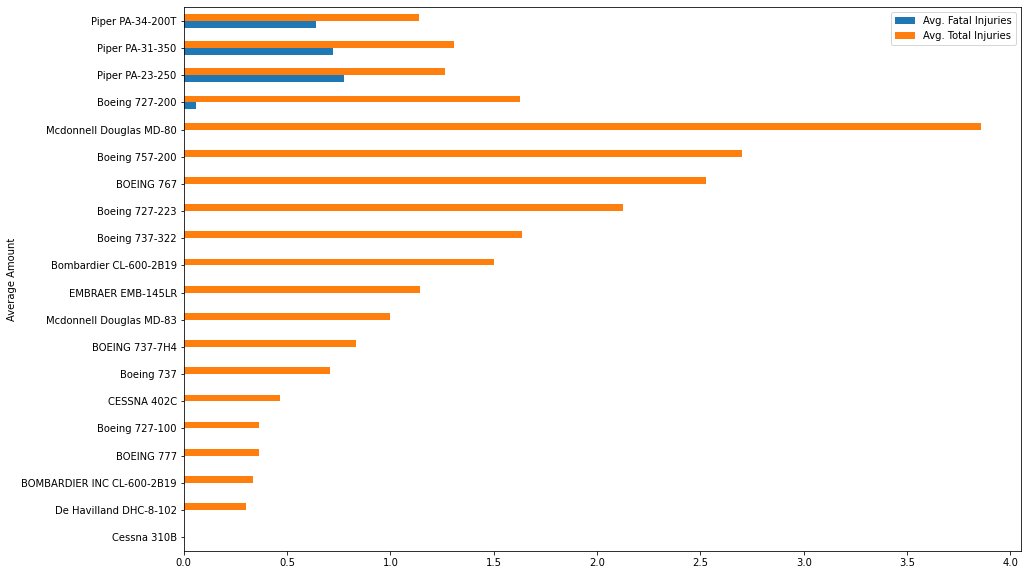

In [60]:
ax = avg_fatalities.plot.barh(y=['Total.Fatal.Injuries', 'Total.Injuries'], figsize=(15,10), ylabel='Make and Model', xlabel='Average Amount')
ax.set_yticklabels(avg_fatalities['Make&Model']);
ax.legend(labels=['Avg. Fatal Injuries', 'Avg. Total Injuries']);

This graph shows a comparison of average total injuries per incident vs average fatal injuries per incident for the top 20 aircraft with the lowest values for each. The Cessna 310B has snuck in as the statistically safest aircraft by my own statistical measure, but I believe that it is not relevant to the specific business interests of the shareholders. My statistical analysis has determined that the top 5 overall safest commercial aircraft are:

1.De Havilland DHC-8-102

2.BOMBARDIER INC CL-600-2B19

3.BOEING 777

4.Boeing 727-100

5.CESSNA 402C

These are all excellent choices for investment due to their low likelihood of fatalities in the event of a safety incident.

### 2. Performance during poor weather conditions

For the next two analyses, I will focus in on those top 5 safest planes in an attempt to determine which one is the overall safest by considering other factors. First, I will focus on their performance in poor weather conditions.

In [ ]:
df.pivot()

In [61]:
### Group by make and model, and then count up the total number of incidents for each. Turn the grouped structure back into a 
### dataframe, combine make and model labels into a new column, then delete the originals. Trim the data to the top 20 results
### and then plot it.
total_incidents = df.groupby(['Make&Model']).size().sort_values()
total_incidents=total_incidents.reset_index()
total_incidents=total_incidents.rename(columns={0:'Incident Count'})
total_incidents = total_incidents.tail(20)
total_incidents.std()

Incident Count    415.024701
dtype: float64

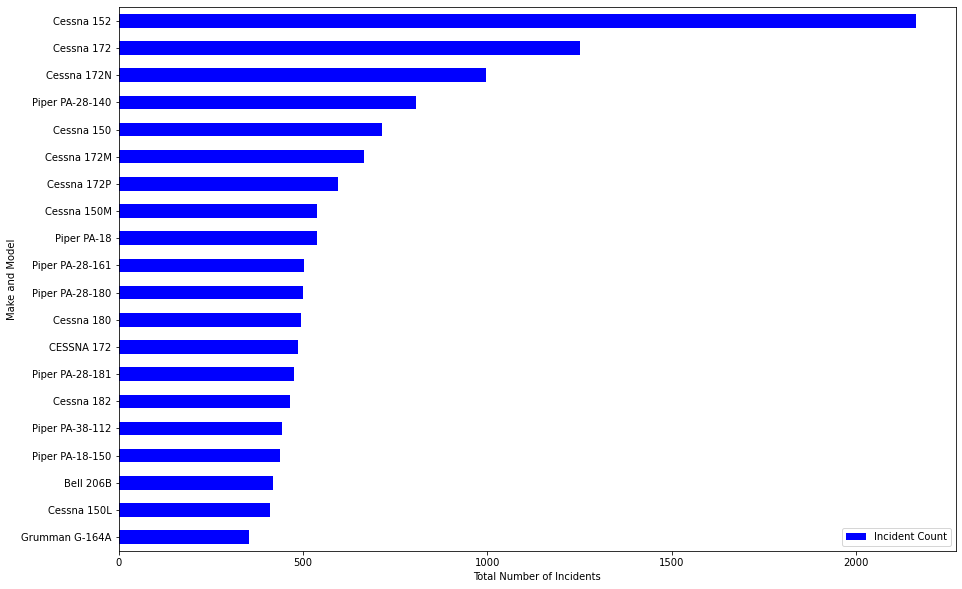

In [62]:
ax = total_incidents.plot.barh(y='Incident Count', x='Make&Model', figsize=(15,10), color='Blue', ylabel='Make and Model')
ax.set_ylabel('Make and Model')
ax.set_xlabel('Total Number of Incidents');

As we can see above, the makes and models with the highest total number of incidents are Piper and Cessna airplanes, which are all low-capacity consumer grade aircraft. It makes sense that so many of the incidents would be related to these aircraft as they are typically used to train new pilots and as recreational craft by hobbyists, who do not follow the same safety requirements as professional pilots. These planes also lack many of the features of larger commercial aircraft.

But which makes and models have the highest total number of fatalities attributed to them?

In [63]:
total_fatalities = df.groupby(['Make&Model'])['Total.Fatal.Injuries'].sum().sort_values()
total_fatalities=total_fatalities.reset_index()
total_fatalities = total_fatalities.tail(20)

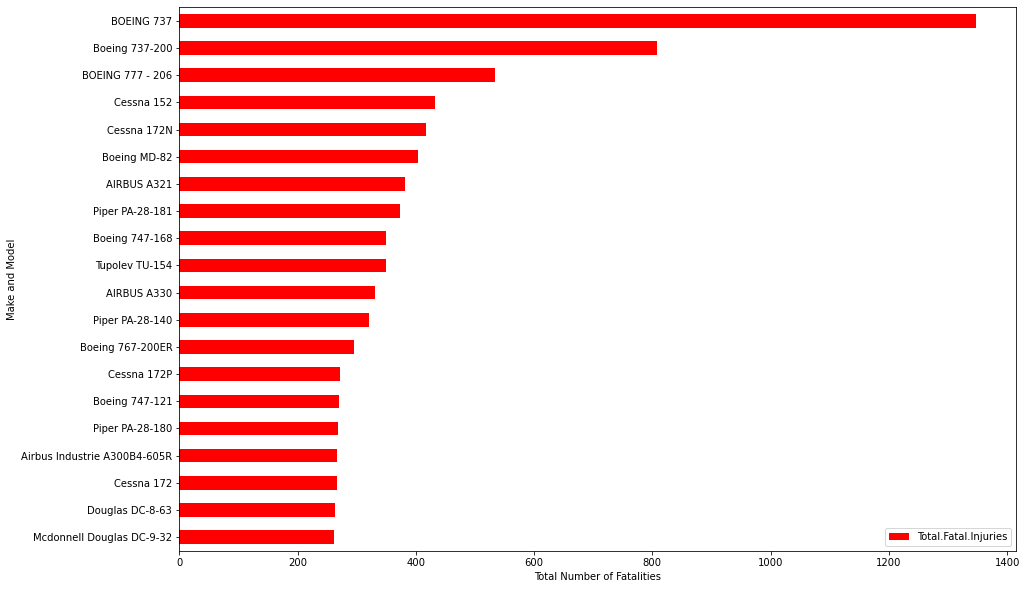

In [64]:
ax = total_fatalities.plot.barh(y='Total.Fatal.Injuries', x='Make&Model', figsize=(15,10), color='Red', ylabel='Make and Model')
ax.set_ylabel('Make and Model')
ax.set_xlabel('Total Number of Fatalities');

In [65]:
amateur_built = df.loc[df['Amateur.Built'] == False].groupby(['Make&Model'])['Amateur.Built'].size().sort_values()
amateur_built.tail(25)

Make&Model
Piper PA-23-250     295
Piper PA-24-250     308
Cessna 170B         309
Cessna 140          320
Piper PA-32-300     325
Grumman G-164A      352
Cessna 150L         408
Bell 206B           417
Piper PA-18-150     436
Piper PA-38-112     441
Cessna 182          462
Piper PA-28-181     474
CESSNA 172          487
Cessna 180          494
Piper PA-28-180     498
Piper PA-28-161     499
Cessna 150M         534
Piper PA-18         537
Cessna 172P         595
Cessna 172M         665
Cessna 150          714
Piper PA-28-140     801
Cessna 172N         992
Cessna 172         1246
Cessna 152         2159
Name: Amateur.Built, dtype: int64

In [66]:
fatalities_by_mnm = df.groupby(['Make&Model'])['Total.Fatal.Injuries'].sum()
fatalities_by_mnm

Make&Model
107.5 Flying Corporation One Design DR 107    1.0
1200 G103                                     0.0
177MF LLC PITTS MODEL 12                      0.0
1977 Colfer-chan STEEN SKYBOLT                0.0
1st Ftr Gp FOCKE-WULF 190                     1.0
                                             ... 
de Havilland DHC-2 MK I                       2.0
de Havilland DHC-3                            0.0
de Havilland DHC-6-200                        0.0
de Havilland DHC-8-202                        0.0
unknown kit                                   0.0
Name: Total.Fatal.Injuries, Length: 19918, dtype: float64

In [67]:
uninjured_by_mnm = df.groupby(['Make&Model'])['Total.Uninjured'].sum()
ratio = uninjured_by_mnm/fatalities_by_mnm

In [68]:
ratio.sort_values(na_position='first')

Make&Model
177MF LLC PITTS MODEL 12         NaN
2001 Mcgirl QUESTAIR VENTURE     NaN
781569 INC FX 210                NaN
A Pair Of Jacks RV-6A            NaN
A. Le Francois RANS S-7          NaN
                                ... 
CALCOTE CLARENCE E Glasair RG    inf
C.w. Smith Rans S6 Coyote II     inf
Lake LA04                        inf
Lake LA250                       inf
de Havilland DHC-8-202           inf
Length: 19918, dtype: float64

# TO DOS:

## find average amount of fatalities for each make and model by weather condition
This is to determine which makes/models have the best performance in poor weather.

## Find average number of fatalities for each make and model by amateur built true or false
This will determine whether buying used amateur built aircraft may raise the risk of incidents.

## Which makes and models have the lowest number of fatalities per incident?
The makes and models with the lowest average number of fatalities per incident are most likely to be the safest options. Exclude all makes and models more than 1 standard deviation away from the mean (this will hopefully clear out the records of makes and models that only have one incident on record).

In [69]:
avg_fatalities_weather = df.groupby(['Make&Model', 'Weather.Condition'])['Total.Fatal.Injuries'].mean().sort_values()
avg_fatalities_weather = avg_fatalities_weather.reset_index()
avg_fatalities_weather

,Make&Model,Weather.Condition,Total.Fatal.Injuries
0,Gulfstream AA5B,VMC,0.0
1,Korsch Classic IV,VMC,0.0
2,Kosch WHITEHEAD #21,VMC,0.0
3,Koskella LONG EZ,VMC,0.0
4,Koster MURPHY REBEL,VMC,0.0
...,...,...,...
21426,Boeing 767-366-ER,VMC,217.0
21427,Boeing 747-300,IMC,228.0
21428,BOEING 777 - 206,VMC,267.0
21429,Tupolev TU-154,VMC,349.0


In [70]:
avg_fatalities_amateur = df.groupby(['Make&Model', 'Amateur.Built'])['Total.Fatal.Injuries'].mean().sort_values()
avg_fatalities_amateur = avg_fatalities_amateur.reset_index()
avg_fatalities_amateur.pivot(index='Make&Model', columns='Amateur.Built', values='Total.Fatal.Injuries')

Amateur.Built,False,True
Make&Model,,
107.5 Flying Corporation One Design DR 107,NaN,1.0
1200 G103,0.0,NaN
177MF LLC PITTS MODEL 12,0.0,NaN
1977 Colfer-chan STEEN SKYBOLT,NaN,0.0
1st Ftr Gp FOCKE-WULF 190,NaN,1.0
...,...,...
de Havilland DHC-2 MK I,2.0,NaN
de Havilland DHC-3,0.0,NaN
de Havilland DHC-6-200,0.0,NaN


In [71]:
avg_fatalities = df.groupby(['Make&Model'])['Total.Fatal.Injuries'].mean()
avg_fatalities

Make&Model
107.5 Flying Corporation One Design DR 107    1.0
1200 G103                                     0.0
177MF LLC PITTS MODEL 12                      0.0
1977 Colfer-chan STEEN SKYBOLT                0.0
1st Ftr Gp FOCKE-WULF 190                     1.0
                                             ... 
de Havilland DHC-2 MK I                       2.0
de Havilland DHC-3                            0.0
de Havilland DHC-6-200                        0.0
de Havilland DHC-8-202                        0.0
unknown kit                                   0.0
Name: Total.Fatal.Injuries, Length: 19918, dtype: float64

In [72]:
total_incidents = df.groupby(['Make&Model']).size()
total_incidents

Make&Model
107.5 Flying Corporation One Design DR 107    1
1200 G103                                     1
177MF LLC PITTS MODEL 12                      1
1977 Colfer-chan STEEN SKYBOLT                1
1st Ftr Gp FOCKE-WULF 190                     1
                                             ..
de Havilland DHC-2 MK I                       1
de Havilland DHC-3                            1
de Havilland DHC-6-200                        1
de Havilland DHC-8-202                        1
unknown kit                                   1
Length: 19918, dtype: int64

In [73]:
ratio = total_incidents/avg_fatalities

In [74]:
ratio.replace([np.inf, -np.inf], 0, inplace=True)
ratio.sort_values().tail(20)

Make&Model
Piper PA-18-150     1425.141791
Piper PA18          1512.500000
Cessna A188B        1543.320755
Cessna 182          1594.785185
Hiller UH-12E       1595.076923
Rockwell S2R        1600.000000
PIPER PA-18-150     1632.363636
Grumman G-164B      1701.000000
Cessna 172M         1863.680672
Piper PA-28-140     2033.844237
Piper PA-38-112     2044.260417
Cessna 180          2159.610619
Cessna 172N         2378.935252
Piper PA-18         2403.075000
Cessna 140          2453.357143
Cessna 150M         2793.471154
Grumman G-164A      3894.031250
Cessna 150          5680.277778
Cessna 172          5883.462406
Cessna 152         10805.009238
dtype: float64